<a href="https://colab.research.google.com/github/t-a-m-a-r-a/t-a-m-a-r-a/blob/main/A_B_results_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Анализ результатов A/B–тестирования гипотезы о введении новой механики оплаты на сайте

## Задача

Выяснить, стоит ли запускать новую механику оплаты на всех пользователей.
Цель введения новой механики оплаты услуг на сайте - увеличить количество совершаемых пользователями покупок, а также доход с покупок.

## Метрики и статистические критерии:

Для проверки гипотез о влиянии новой оплаты на поведение пользователей выбраны следующие метрики и критерии для них:
* Конверсия из посещения платформы в покупку CR - критерий хи-квадрат    
*Средний доход на платящего пользователя ARPPU - бутстрап
*Cредний доход с активного пользователя ARPAU - бутстрап

### Входные данные
    groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
    groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
    active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
    checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.

### Проверка и предобработка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# import pandahouse as ph
import numpy as np
import seaborn as sns
import scipy. stats

In [ ]:
groups = pd.read_csv \
    ('/content/drive/MyDrive/pet_project_a_b_test/groups.csv', sep=';')

In [ ]:
groups.head(2)  # просмотр данных

,id,grp
0,1489,B
1,1627,A


In [ ]:
groups.info()  # проверка пропусков и типов данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
groups.nunique()  # проверка уникальных значений

id     74484
grp        2
dtype: int64

Таблица groups не содержит пропуски, все id пользователей уникальны и имеют формат целого числа, каждый пользователь однозначно отнесен к одной из групп (А или В).

In [ ]:
groups_add = pd.read_csv('/content/drive/MyDrive/pet_project_a_b_test/group_add.csv')

In [ ]:
groups_add.head(2)  # просмотр данных

,id,grp
0,5694584,B
1,5694830,B


In [ ]:
groups_add.info()  # проверка пропусков и типов данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [ ]:
groups_add.nunique()  # проверка уникальных значений

id     92
grp     2
dtype: int64

Таблица groups_add не содержит пропуски, все id пользователей уникальны и имеют формат целого числа, каждый пользователь однозначно отнесен к одной из групп (А или В).

In [ ]:
active_studs = pd.read_csv('/content/drive/MyDrive/pet_project_a_b_test/active_studs.csv')

In [ ]:
active_studs.head(2)  # просмотр данных

,student_id
0,581585
1,5723133


In [ ]:
active_studs.info()  # проверка пропусков и типов данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [ ]:
active_studs.nunique()  # проверка уникальных значений

student_id    8341
dtype: int64

Таблица active_studs не содержит пропуски, все id пользователей уникальны и имеют формат целого числа, но название колонки отличается от названия аналогичной колонки в таблицах groups и groups_add.

In [ ]:
checks = pd.read_csv('/content/drive/MyDrive/pet_project_a_b_test/checks.csv', sep=';')

In [ ]:
checks.head(2)  # просмотр данных

,student_id,rev
0,1627,990.0
1,3185,690.0


In [ ]:
checks.info()  # проверка пропусков и типов данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [ ]:
checks.student_id.nunique()  # проверка уникальных значений

541

Таблица checks не содержит пропуски, все id пользователей уникальны и имеют формат целого числа, но название колонки отличается от названия аналогичной колонки в таблицах groups и groups_add. Сумма платежа имеет формат числа с плавающей запятой.

In [ ]:
groups_full = pd.concat([groups, groups_add], ignore_index=True)  # объединение таблиц groups и groups_add.

In [ ]:
groups_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
grp_A = set(groups_full.query('grp=="A"').id)
grp_B = set(groups_full.query('grp=="B"').id)

grp_A.intersection(grp_B)  # проверка пересечений в группах

set()

In [ ]:
active_studs_extended = active_studs.merge(checks, how='left', on='student_id')
# объединение данных об активных пользователях с данными об оплатах

In [ ]:
active_studs_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   rev         392 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 130.5 KB


После объединения данных уменьшилось число оплат. Таким образом 149 пользователей совершили покупку не заходя на платформу.

In [ ]:
not_active_payed = checks.merge(active_studs, how='left', on='student_id', indicator=True) \
    .query("_merge == 'left_only'") \
    .drop('_merge', axis=1).student_id  # список пользователей, не участвующих в анализе

In [ ]:
active_studs_extended = active_studs_extended.merge(groups_full, how='left', left_on='student_id', right_on='id')
# добавление информации о принадлежности к одной из групп

In [ ]:
active_studs_extended.info()  # проверка на пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   rev         392 non-null    float64
 2   id          8341 non-null   int64  
 3   grp         8341 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 260.8+ KB


  27% пользователей совершили покупку не заходя на платформу (149 из 541 пользователя есть в таблице checks, но отсутствуют в таблице active_studs).

 Необходимо знать причину (автоматические списания, зависшие платежи или ошибки при сборе данных?) и при необходимости скорректировать исходные данные.


**Анализ произведен исходя из следующих условий:**
1. каждый пользователь однозначно отнесен к одной из групп (А или В),
2. участие пользователя в тесте определяется его входом на платформу в дни проведения эксперимента. Другими словами, <p style="color:red;"> пользователи совершившие оплату в дни проведения эксперимента, но не зашедшие на платформу исключены из анализа.</p>


### Выбор метрик

Исходя из конечной цели введения новой механики оплаты - повышения дохода, ожидаемый эффект - увеличение количества и/или суммы покупок.

Основными метриками являются:

**Конверсия из посещения платформы в покупку CR** = (Количество покупок / Число активных пользователей) * 100%.
    
**Средний доход на платящего пользователя ARPPU** (Будет совпадать со средним чеком, так как каждый покупатель совершил только одну покупку) = (Доход / Количество покупок)

Дополнительно будут рассмотрены метрики:

**Cредний доход с активного пользователя ARPAU** = (Доход / Число активных пользователей).

## Расчет и оценка метрик

#### CR to payment

In [ ]:
active_studs_extended['payment'] = active_studs_extended.rev.notna()
# новая колонка со статусом оплаты - произведена (TRUE) или нет (FALSE)

In [ ]:
active_studs_extended.payment = active_studs_extended.payment.astype(int)
# в итоговой таблице статус оплаты обозначен цифрами "0" - оплата не произведена, "1" - оплата произведена

In [ ]:
active_studs_extended.rev = active_studs_extended.rev.fillna(0)  # заполнение пропусков в сумме оплаты нулями

In [ ]:
active_studs_extended.head(2)

,student_id,rev,id,grp,payment
0,581585,0.0,581585,A,0
1,5723133,0.0,5723133,A,0


In [ ]:
active_studs_extended.grp.value_counts()  # размеры выборок активных пользователей.

grp
B    6803
A    1538
Name: count, dtype: int64

In [ ]:
group_A = active_studs_extended.query('grp == "A"')  # данные о контрольной группе

In [ ]:
group_B = active_studs_extended.query('grp == "B"')  # данные о целевой группе

In [ ]:
CR_to_payment_A = round(100 * group_A.payment.sum() / group_A.student_id.count(), 2)  # конверсия в контрольной группе
CR_to_payment_A

5.07

In [ ]:
CR_to_payment_B = round(100 * group_B.payment.sum() / group_B.student_id.count(), 2)  # конверсия в целевой группе
CR_to_payment_B

4.62

**Конверсия в целевой группе (4,62%) ниже конверсии в контрольной группе (5,07%).**

Различия в значениях есть, проверяется статистическая значимость.

Статус оплаты - категориальная переменная, статистическая значимость проверяется с помощью критерия Хи-квадрат.

H0 - Конверсии пользователей в покупателей в тестовой и контрольной группах равны.

Н1 - Конверсия пользователей в покупателей в тестовой группе выше, чем в контрольной.

In [ ]:
payment_crosstab = pd.crosstab(active_studs_extended.grp, active_studs_extended.payment)
# таблица кросс-табуляции показывает, сколько пользователей в каждой группе совершили и не совершили покупку

In [ ]:
payment_crosstab

payment,0,1
grp,,
A,1460,78
B,6489,314


In [ ]:
CR_to_payment_stat = scipy. stats.chi2_contingency(payment_crosstab)
CR_to_payment_pvalue = round(CR_to_payment_stat.pvalue, 2)
CR_to_payment_pvalue

0.49

pvalue = 0.49 > 0.05 --> **нет оснований говорить о статистичексой значимости различий конверсии в двух группах.**

#### ARPPU

In [ ]:
active_studs_buyers = active_studs_extended.query('rev != 0')  # отбор покупателей

In [ ]:
active_studs_buyers.grp.value_counts()  # размеры выборок покупателей.

grp
B    314
A     78
Name: count, dtype: int64

In [ ]:
group_A_buyers = group_A.query('rev != 0')

In [ ]:
group_B_buyers = group_B.query('rev != 0')

In [ ]:
ARPPU_A = round(group_A_buyers.rev.sum() / group_A_buyers.student_id.count(), 1)  # ARPPU в контрольной группе
ARPPU_A

933.6

In [ ]:
ARPPU_B = round(group_B_buyers.rev.sum() / group_B_buyers.student_id.count(), 1)  # ARPPU в целевой группе
ARPPU_B

1257.9

ARPPU в целевой группе (1257.9) выше чем ARPPU в контрольной группе (933.6).

Различия в значениях есть, проверяется статистическая значимость.

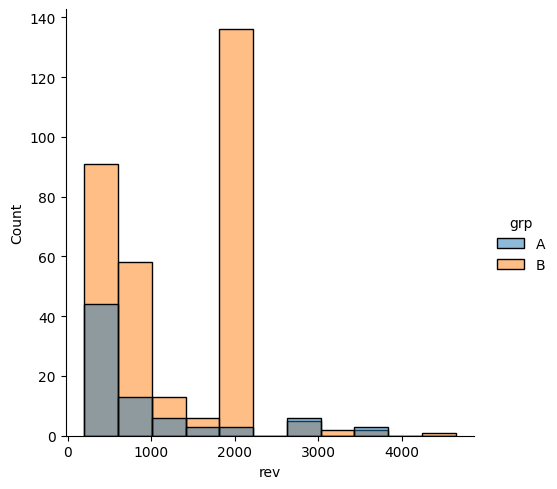

In [ ]:
sns.displot(data=active_studs_buyers, x='rev', hue='grp')  # распределение суммы чека в группах

Форма распределения значений в группах не только не близка к нормальному распределению, но и различна в двух группах за счет пика значений в примерно 2000 в целевой группе.

Text(0, 0.5, 'Группа')

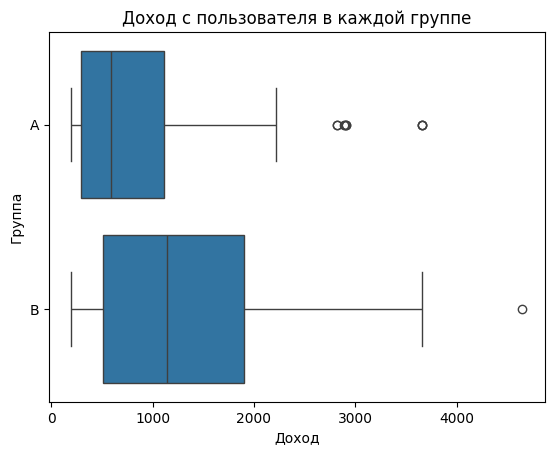

In [ ]:
sns.boxplot(x='rev', y='grp', data=active_studs_buyers)
plt.title('Доход с пользователя в каждой группе')
plt.xlabel('Доход')
plt.ylabel('Группа')

В целевой группе наблюдается увеличение межквартильного размаха и смещение медианы  вправо относительно контрольной группы. В контрольной группе наблюдается большое количество выбросов.

Выбросы и ненормальное распределение не позволяют опираться на t-критерий, непараметрический тест не сравнивает средние значения в выборках. Таким образом наиболее надежной для данных выборок является методика бутстрап.

Далее с помощью бутстрапа проверяется разница между средними значениями в группах.

H0 - Новый механизм оплаты не влияет на средний доход с платящего пользователя.

Н1 - Новый механизм оплаты влияет на средний доход с платящего пользователя.

In [ ]:
ARPPU_bootstrap = scipy.stats.bootstrap([group_A_buyers.rev,
                                        group_B_buyers.rev],
                                        statistic=lambda x, y: np.mean(y) - np.mean(x))

In [ ]:
ARPPU_bootstrap

BootstrapResult(confidence_interval=ConfidenceInterval(low=82.22918535381062, high=526.0142618957541), bootstrap_distribution=array([276.49004807, 230.40773516, 282.89858996, ..., 310.44317817,
       142.59906645, 367.17566066]), standard_error=112.5331355914707)

<Axes: ylabel='Count'>

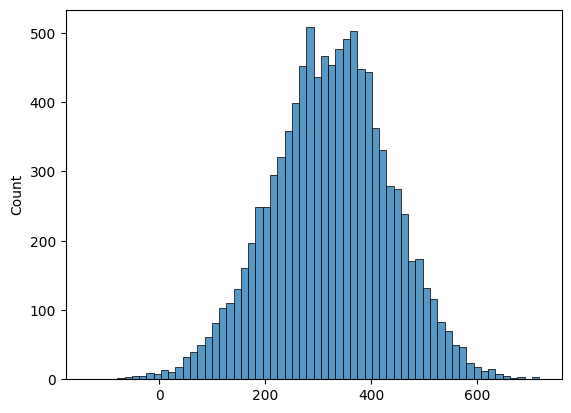

In [ ]:
sns.histplot(data=ARPPU_bootstrap.bootstrap_distribution)

In [ ]:
ARPPU_CI = [round(ARPPU_bootstrap.confidence_interval.low, 2), round(ARPPU_bootstrap.confidence_interval.high, 2)]
ARPPU_CI # доверительный интервал

[82.23, 526.01]

0 не попадает в доверительный интервал, следовательно **ARPPU в двух группах статистически значимо различаются**.

#### ARPAU

In [ ]:
ARPAU_A = round(group_A.rev.sum() / group_A.student_id.count(), 1)  # ARPAU в контрольной группе
ARPAU_A

47.3

In [ ]:
ARPAU_B = round(group_B.rev.sum() / group_B.student_id.count(), 1)  # ARPAU в целевой группе
ARPAU_B

58.1

ARPAU в целевой группе (58.1) выше чем ARPAU в контрольной группе (47.3).

Различия в значениях есть, проверяется статистическая значимость.

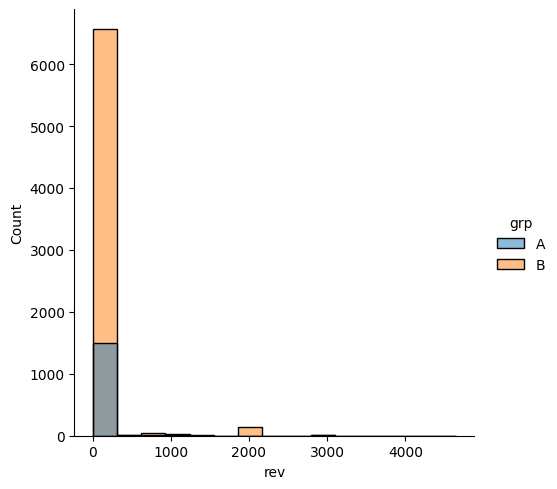

In [ ]:
sns.displot(data=active_studs_extended, x='rev', hue='grp')  # распределение суммы чека в группах

Форма распределения значений в группах не близка к форме нормального распределения.
Число наблюдений в наименьшей из сравниваемых выборок достаточно для проведения t-теста, но из-за большого количества выбросов есть риск получить некорректный результат.
Непараметрический тест не сравнивает средние значения в выборках. Таким образом наиболее надежной для данных выборок является методика бутстрап.

Далее с помощью бутстрапа проверяется разница между средними значениями в группах.

H0 - Новый механизм оплаты не влияет на средний доход с активного пользователя.

Н1 - Новый механизм оплаты влияет на средний доход с активного пользователя.

In [ ]:
ARPAU_bootstrap = scipy.stats.bootstrap([group_A.rev,
                                        group_B.rev],
                                        statistic=lambda x, y: np.mean(y) - np.mean(x))

In [ ]:
ARPAU_bootstrap

BootstrapResult(confidence_interval=ConfidenceInterval(low=-7.463677337423757, high=25.713872774723992), bootstrap_distribution=array([ 9.63351611, 21.04211755, 19.92047165, ..., 15.60607767,
       25.8709112 ,  4.78490912]), standard_error=8.443245783094142)

<Axes: ylabel='Count'>

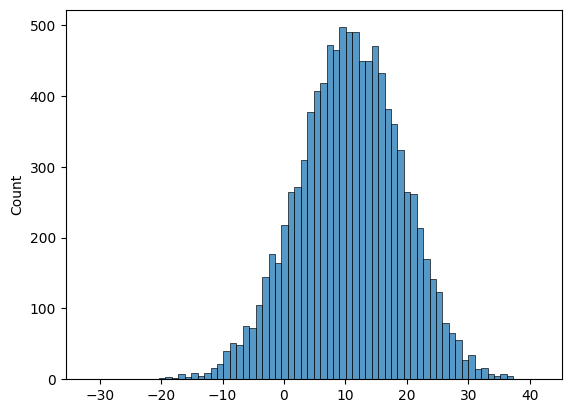

In [ ]:
sns.histplot(data=ARPAU_bootstrap.bootstrap_distribution)

In [ ]:
ARPAU_CI = [round(ARPAU_bootstrap.confidence_interval.low, 2), round(ARPAU_bootstrap.confidence_interval.high, 2)]
ARPAU_CI # доверительный интервал

[-7.46, 25.71]

В результате получен доверительный интервал: [-7.13, 25.81]

0 попадает в доверительный интервал. **ARPAU в двух группах статистически значимо не различаются**.

## Вывод

In [ ]:
metrics_task_01 = pd.DataFrame(data={'Version': ['task_01'],
                                     'CR_A': [CR_to_payment_A],
                                     'CR_B': [CR_to_payment_B],
                                     'CR_pvalue': [CR_to_payment_pvalue],
                                     'ARPPU_A': [ARPPU_A],
                                     'ARPPU_B': [ARPPU_B],
                                     'ARPPU_CI': [ARPPU_CI],
                                     'ARPAU_A': [ARPAU_A],
                                     'ARPAU_B': [ARPAU_B],
                                     'ARPAU_CI': [ARPAU_CI]})
metrics_task_01

,Version,CR_A,CR_B,CR_pvalue,ARPPU_A,ARPPU_B,ARPPU_CI,ARPAU_A,ARPAU_B,ARPAU_CI
0,task_01,5.07,4.62,0.49,933.59,1257.88,"[82.23, 526.01]",47.35,58.06,"[-7.46, 25.71]"


Новая механика оплаты позволит увеличить средний доход на платящего пользователя (ARPPU), но при этом не простимулирует пользователей к покупке (увеличение конверсии в покупку и среднего дохода на активного пользователя не подтверждено)
